In [1]:
#import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping


In [2]:
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools

In [3]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

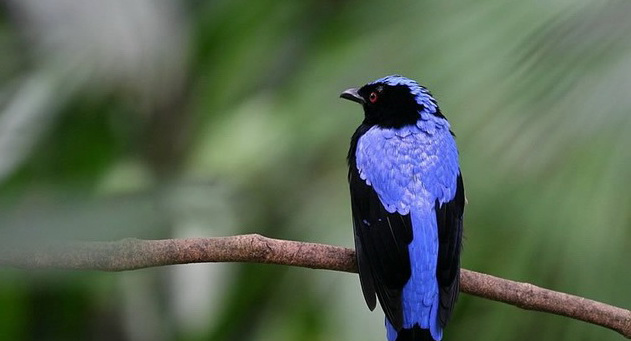

In [4]:
real_image_path = "D:\\archive\\CASIA2 Dataset\\Au\\Au_ani_20054.jpg"
Image.open(real_image_path)

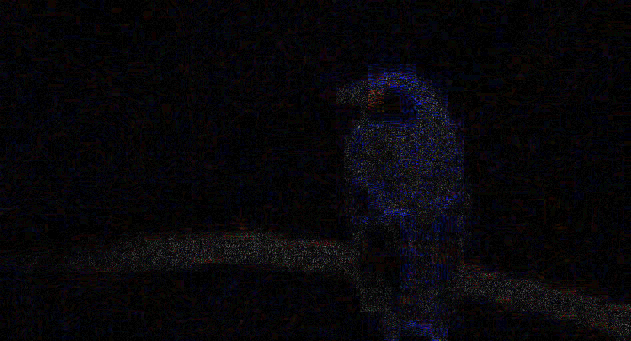

In [5]:
convert_to_ela_image(real_image_path, 90)

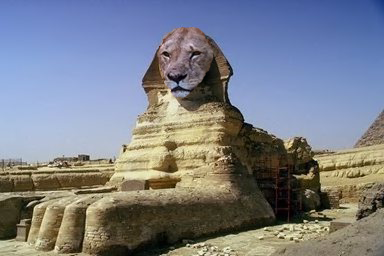

In [6]:
fake_image_path = "D:\\archive\\CASIA2 Dataset\\Tp\\Tp_D_CRN_M_O_arc00027_ani00030_10005.tif"
Image.open(fake_image_path)

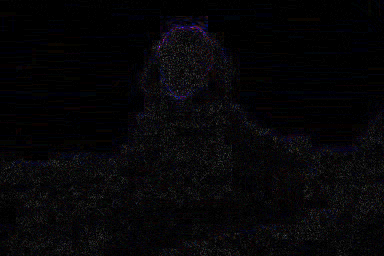

In [7]:
convert_to_ela_image(fake_image_path, 90)

In [8]:
image_size = (128, 128)

In [9]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [10]:
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [11]:
import random
path = "D:\\archive\\CASIA2 Dataset\\Au"
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [12]:
path = 'D:\\archive\\CASIA2 Dataset\\Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [13]:
from keras.utils import to_categorical

In [14]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [16]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model


In [17]:
model = build_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                        

In [18]:
epochs = 10
batch_size = 32


In [19]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy', metrics = ['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'auto')

In [21]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val))

Epoch 1/10
105/105 [==============================] - 254s 2s/step - loss: 0.5638 - accuracy: 0.6920 - val_loss: 0.5851 - val_accuracy: 0.6086
Epoch 2/10
105/105 [==============================] - 245s 2s/step - loss: 0.4423 - accuracy: 0.7902 - val_loss: 0.3414 - val_accuracy: 0.8679
Epoch 3/10
105/105 [==============================] - 266s 3s/step - loss: 0.3431 - accuracy: 0.8760 - val_loss: 0.3840 - val_accuracy: 0.8487
Epoch 4/10
105/105 [==============================] - 251s 2s/step - loss: 0.3001 - accuracy: 0.8877 - val_loss: 0.4077 - val_accuracy: 0.8379
Epoch 5/10
105/105 [==============================] - 240s 2s/step - loss: 0.2447 - accuracy: 0.9096 - val_loss: 0.2635 - val_accuracy: 0.9028
Epoch 6/10
105/105 [==============================] - 231s 2s/step - loss: 0.1774 - accuracy: 0.9388 - val_loss: 0.2201 - val_accuracy: 0.9112
Epoch 7/10
105/105 [==============================] - 223s 2s/step - loss: 0.1289 - accuracy: 0.9466 - val_loss: 0.3088 - val_accuracy: 0.8715

In [22]:
model.save('model_casia_run1.h5')

C:\Users\shikh\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


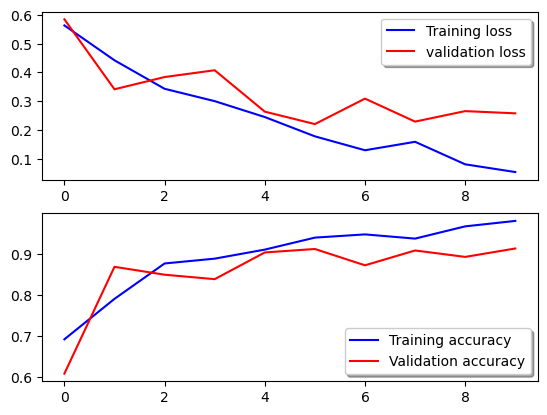

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(hist.history['loss'], color='b', label="Training loss")
ax[0].plot(hist.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(hist.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

27/27 [==============================] - 9s 315ms/step


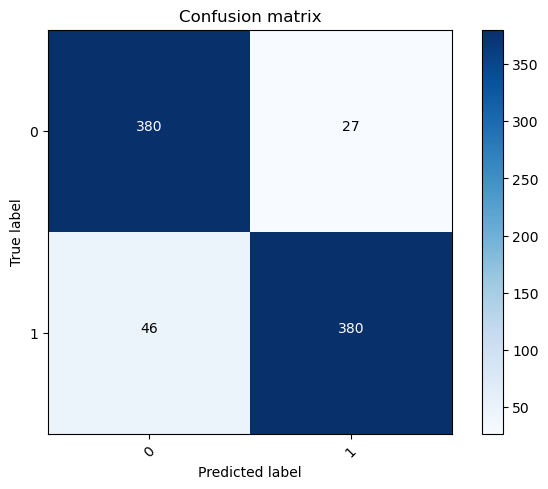

In [25]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))


In [26]:
class_names = ['fake', 'real']

In [27]:
real_image_path = "D:\\archive\\CASIA2 Dataset\\Au\\Au_ani_10132.jpg"
image = prepare_image(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 80ms/step
Class: real Confidence: 100.00


In [28]:
fake_image_path = "D:\\archive\\CASIA2 Dataset\\Tp\Tp_D_CNN_M_N_sec00011_cha00085_11227.jpg"
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 64ms/step
Class: fake Confidence: 99.83


In [29]:
fake_image = os.listdir('D:\\archive\\CASIA2 Dataset\\Tp\\')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('D:\\archive\\CASIA2 Dataset\\Tp\\', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 63ms/step


In [30]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')


Total: 2064, Correct: 2030, Acc: 98.35271317829456


In [32]:
real_image = os.listdir('D:\\archive\\CASIA2 Dataset\\Au\\')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('D:\\archive\\CASIA2 Dataset\\Au\\', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 143ms/step


In [33]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6818, Acc: 92.71144955126461
Total: 9418, Correct: 8848, Acc: 93.94775960925887


In [34]:
class_names = ['fake', 'real']

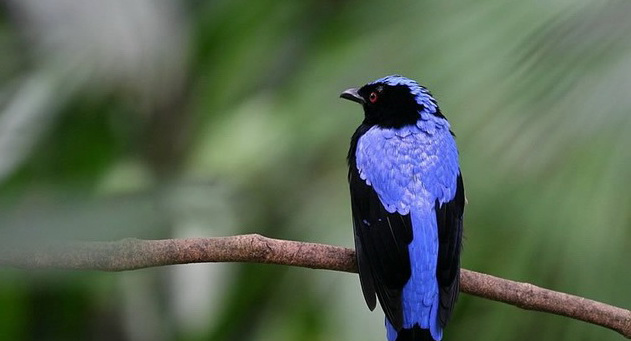

In [35]:
real_image_path = "D:\\archive\\CASIA2 Dataset\\Au\\Au_ani_20054.jpg"
Image.open(real_image_path)

In [36]:
image_path = "D:\\archive\\CASIA2 Dataset\\Au\\Au_ani_20054.jpg"
image = prepare_image(image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred)
print(f'Class: {class_names[y_pred_class]}')
if class_names[y_pred_class]=='real':
    print("The image is Authentic")
else:
    print("The image is Tampered")

1/1 [==============================] - 0s 167ms/step
Class: real
The image is Authentic


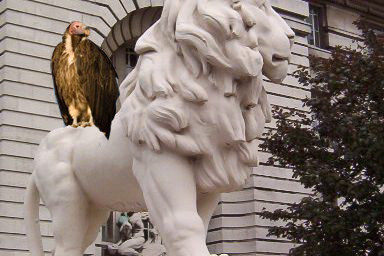

In [37]:
fake_image_path ="D:\\archive\\CASIA2 Dataset\\Tp\\Tp_D_CNN_S_N_art00001_ani00074_10442.tif"
Image.open(fake_image_path)

In [38]:
image_path = "D:\\archive\\CASIA2 Dataset\\Tp\\Tp_D_CNN_S_N_art00001_ani00074_10442.tif"
image = prepare_image(image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis=1)[0]
print(f'Class: {class_names[y_pred_class]}')
if class_names[y_pred_class]=='real':
    print("The image is Authentic")
else:
    print("The image is Tampered")

1/1 [==============================] - 0s 151ms/step
Class: fake
The image is Tampered
